# Attempting Plotly Dash

In [1]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output
from dash.exceptions import PreventUpdate
import plotly.graph_objects as go
import pandas as pd
import numpy as np

In [2]:
def get_stations(list_stations):
    dict_list = []
    for i in list_stations:
        dict_list.append({'label': i, 'value': i})

    return dict_list



In [3]:
#Load data
df = pd.read_csv('../data/anomalies-testdata.csv',index_col=0, parse_dates=True)
zähler = ['1061','1077']

for z in zähler:
    df[f'Z{z}_pred'] = df[f'Z{z}'] + df[f'Z{z}_proph-resid']

In [4]:
## Release datetime index into column
df.reset_index(inplace=True)
df['year'] = df.datetime.dt.year

In [5]:
df.head(1)

,datetime,Z1061,Z1077,Z1061_tdiff_7day,Z1077_tdiff_7day,Z1061_anoms_day,Z1077_anoms_day,Z1061_proph-resid,Z1077_proph-resid,Z1061_pred,Z1077_pred,year
0,2012-11-08,51557.0,35134.0,NaN,NaN,1878.0,-1015.0,-348.0,1464.0,51209.0,36598.0,2012


In [6]:
# Build app
app = JupyterDash(__name__)

#Define app
app.layout = html.Div()

#Run app
if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on http://127.0.0.1:8050/


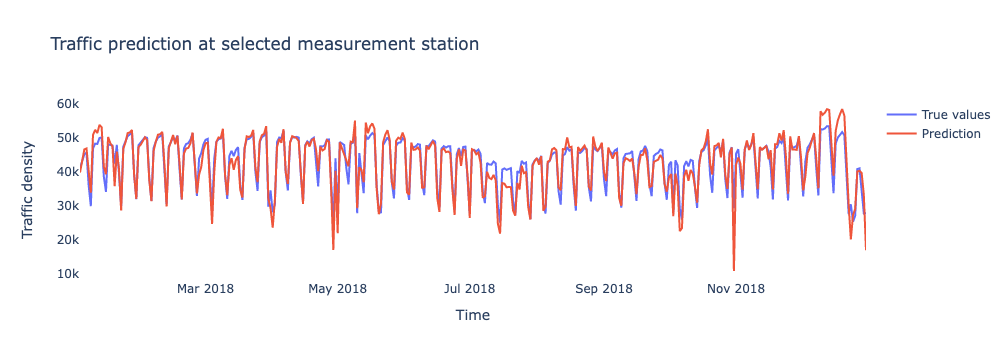

In [29]:
# A nice plot
plot_pred = df[['Z1061','Z1061_pred','datetime','year']]
plot_pred = plot_pred.rename(columns={'Z1061_pred': 'Prediction','Z1061': 'True values'})
plot_pred = plot_pred[plot_pred.datetime > '1/1/2018']
plot_pred = plot_pred.melt(['datetime','year'])


figure1 = px.line(plot_pred,
                         x='datetime',
                         y='value', color='variable', range_x=[plot_pred.datetime.min(),plot_pred.datetime.max()],
                         title='Traffic prediction at selected measurement station',
                          labels={
                     "value": "Traffic density",
                     "datetime": "Time",
                     "variable": ""}).update_layout(
                                   {'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                                    'paper_bgcolor': 'rgba(0, 0, 0, 0)'})
figure1.show()

In [8]:
## Renew plot dataframe to contain all data
plot_pred = df[['Z1061','Z1077','datetime','year']]
plot_pred = plot_pred.melt(['datetime','year'])

In [9]:
## The HTML for the dashboard

app.layout = html.Div(
    children=[
    html.Div(className='row',  # Define the row element
      children=[
            html.Div(className='four columns div-user-controls',
                  children = [
                        html.H1('Hamburg Traffic Prediction'),
                        html.P('''Visualising traffic and traffic predictions, a basic example for our dashboard''')]),  # Define the left element
            html.Div(className='eight columns div-for-charts bg-grey', 
                  children=[
                        html.Div(className='div-for-dropdown',
                              children=[
                                    dcc.Dropdown(id='Zselector',
                                          options=get_options(plot_pred['variable'].unique()),
                                          multi=True,
                                          value=[plot_pred['variable'].sort_values()[0]],
                                          style={'backgroundColor': '#1E1E1E'},
                                          className='Zselector')]),
                        dcc.Graph(id='timeseries', config={'displayModeBar': False}) 
                        ]
                  )       
            ]
           ) 
            ]
                )

In [10]:
## Renew plot dataframe to contain all data
plot_pred = df[['Z1061','Z1077','Z1061_pred','Z1077_pred','datetime','year']]
plot_pred = plot_pred.melt(['datetime','year'])

In [11]:
@app.callback(Output('timeseries', 'figure'),
              [Input('Zselector', 'value')])
def update_timeseries(selected_dropdown_value):
    ''' Draw traces of the feature 'value' based one the currently selected stocks '''
    if selected_dropdown_value is None:
        raise PreventUpdate
    
    # STEP 1
    trace = []  
    df_ = plot_pred
    # STEP 2
    # Draw and append traces for each stock
    for vari in selected_dropdown_value:
        data_graph = df_.query(f'variable == "{vari}"').iloc[-30:]  
        trace.append(go.Scatter(x=data_graph.datetime,
                                 y=data_graph.value,
                                 mode='lines',
                                 opacity=0.7,
                                 name=vari,
                                 textposition='bottom center'))
        data_graph = df_.query(f'variable == "{vari}_pred"').iloc[-30:]   
        trace.append(go.Scatter(x=data_graph.datetime,
                                 y=data_graph.value,
                                 mode='markers',
                                 opacity=0.7,
                                 name=vari+'_pred',
                                 textposition='bottom center'))   
    # STEP 3
    # traces = [trace]
    data = trace #[val for sublist in traces for val in sublist]
    # Define Figure
    # STEP 4
    figure = {'data': data,
              'layout': go.Layout(
                  colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
                  template='plotly_dark',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  margin={'b': 15},
                  hovermode='x',
                  autosize=True,
                  title={'text': 'Traffic density', 'font': {'color': 'white'}, 'x': 0.5},
                  xaxis={'range': [data_graph.datetime.min(), data_graph.datetime.max()]},
              ),

              }

    return figure

In [171]:
# trace = []  
# df_ = plot_pred
# # STEP 2
# # Draw and append traces for each stock
# for vari in ['Z1061','Z1077']:
#     data_graph = df_.query(f'variable == "{vari}"')  
#     trace.append(go.Scatter(x=data_graph.datetime,
#                              y=data_graph.value,
#                              mode='lines',
#                              opacity=0.7,
#                              name=vari,
#                              textposition='bottom center'))  
# # STEP 3
# traces = [trace]
# data = [val for sublist in traces for val in sublist]
# # Define Figure
# # STEP 4
# figure = {'data': data,
#           'layout': go.Layout(
#               colorway=["#5E0DAC", '#FF4F00', '#375CB1', '#FF7400', '#FFF400', '#FF0056'],
#               template='plotly_dark',
#               paper_bgcolor='rgba(0, 0, 0, 0)',
#               plot_bgcolor='rgba(0, 0, 0, 0)',
#               margin={'b': 15},
#               hovermode='x',
#               autosize=True,
#               title={'text': 'Traffic density', 'font': {'color': 'white'}, 'x': 0.5},
#               xaxis={'range': [df_.datetime.min(), df_.datetime.max()]},
#           ),
#           }

In [172]:
# len(traces)
# len([sublist for sublist in traces])